## Notebook to assign cells to cell-types using MACA

this notebook is based on tutorials from [MACA github](https://github.com/ImXman/MACA)
reference: [https://www.biorxiv.org/content/10.1101/2021.10.25.465734v1]

In [1]:
!date

#### import libraries and set notebook variables

In [2]:
import anndata
import collections
import numpy as np
import pandas as pd
import scanpy as sc
import MACA as maca
from matplotlib.pyplot import rc_context

import warnings
warnings.filterwarnings("ignore")

2022-01-10 11:01:33.526681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# naming
cohort = 'lrrk2_crispr'
maca_db = 'bakken'

# directories
wrk_dir = '/labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x'

# in files
raw_anndata_file = f'{wrk_dir}/{cohort}.merged.raw.h5ad'
panglao_db_url = 'https://raw.githubusercontent.com/ImXman/MACA/master/\
MarkerDatabase/PanglaoDB_markers_27_Mar_2020.tsv'
bakken_db_url = 'https://raw.githubusercontent.com/ImXman/MACA/master/\
MarkerDatabase/human_motorcortex_bakken_markers.csv'

# out files
cell_labels = f'{wrk_dir}/{cohort}.maca.{maca_db}.csv'
pangloa_cell_types = f'{wrk_dir}/{cohort}.maca.pangloa.labels.csv'
bakken_cell_types = f'{wrk_dir}/{cohort}.maca.bakken.labels.csv'

# variables


#### read in the raw cell data

In [4]:
%%time
adata = sc.read(raw_anndata_file, cache=True)

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].
CPU times: user 523 ms, sys: 1.33 s, total: 1.85 s
Wall time: 29 s


In [5]:
adata

AnnData object with n_obs × n_vars = 105683 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target'
    var: 'gene_ids', 'feature_types', 'genome'

#### adjust data for analysis

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.pct_counts_mt < 10, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [7]:
adata

AnnData object with n_obs × n_vars = 94109 × 24579
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [8]:
display(adata.obs.head())

,expr_name,num_features,feature_call,num_umis,target,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGACTACGG-1,ci1-gex-fb,NaN,NaN,NaN,NaN,2208,2208,7911.0,534.0,6.750095
AAACCCAAGCACTAAA-1,ci1-gex-fb,3.0,sgPeak38437_29|sgPeak38441_134|sgPeak38441_319,314|13|230,mixed,4996,4996,27407.0,1479.0,5.396432
AAACCCAAGCCGGAAT-1,ci1-gex-fb,4.0,sgPeak38441_211|sgPeak38441_310|sgPeak38441_33...,136|5|69|25,sgPeak38441,4591,4591,26085.0,1379.0,5.286563
AAACCCAAGGCTCAAG-1,ci1-gex-fb,2.0,sgPeak38441_04|sgPeak38441_266,13|31,sgPeak38441,5753,5753,34377.0,2620.0,7.621375
AAACCCAAGTTTGCTG-1,ci1-gex-fb,4.0,sgNT_24|sgNT_49|sgPeak38433_38|sgPeak38441_196,4|9|14|16,mixed,3745,3745,14111.0,939.0,6.654383


### find cell types using MACA

#### parse in MACA marker database, using PanglaoDB

In [9]:
pg_df = pd.read_table(panglao_db_url)
print(pg_df.shape)
display(pg_df.head())
##remove mouse specific genes
pg_df = pg_df[pg_df['species']!='Mm']
##cell_marker is dictionary that contains names of cell types and their marker genes
cell_markers = {}
marker_list = []
for i in list(set(pg_df["cell type"].values.tolist())):
    genes = pg_df[pg_df["cell type"]==i]['official gene symbol'].values.tolist()
    ##only use cell type with at least 5 genes and less than 300 genes
    if len(genes)>=5 and len(genes)<=300:
        cell_markers[i]=genes
        marker_list+= genes
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)

(8286, 14)


,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
4,Mm,TRY4,Acinar cells,NaN,0.007,trypsin 4,protein coding gene,1.0,Endoderm,Pancreas,NaN,NaN,NaN,NaN


3531

#### compute MACA cell assignments

In [10]:
%%time
mdata = adata.copy()
mdata = mdata[:,marker_list]

##run MACA
mdata, annotation = maca.singleMACA(ad=mdata, cell_markers=cell_markers,
                                 res=[0.5,0.75,1,1.25,1.5],n_neis=[3,5,10,30,50,100])
##we define louvain clustering resolution 1, 1.5 and 2; 
##number of neighbors to define the kNN is 3,5 and 10 separately.
##MACA will get 9 clustering results, using this set of parameteres.
##The final annotation is ensembled via voting.

Trying to set attribute `.obs` of view, copying.


(94109, 164)
(94109, 164)
CPU times: user 3h 19min 21s, sys: 2h 6min 46s, total: 5h 26min 8s
Wall time: 35min 7s


In [11]:
mdata.obs['broadcelltype'] = np.array(annotation)

#### visualize the MACA cell assignments

... storing 'Mapped' as categorical
... storing 'broadcelltype' as categorical


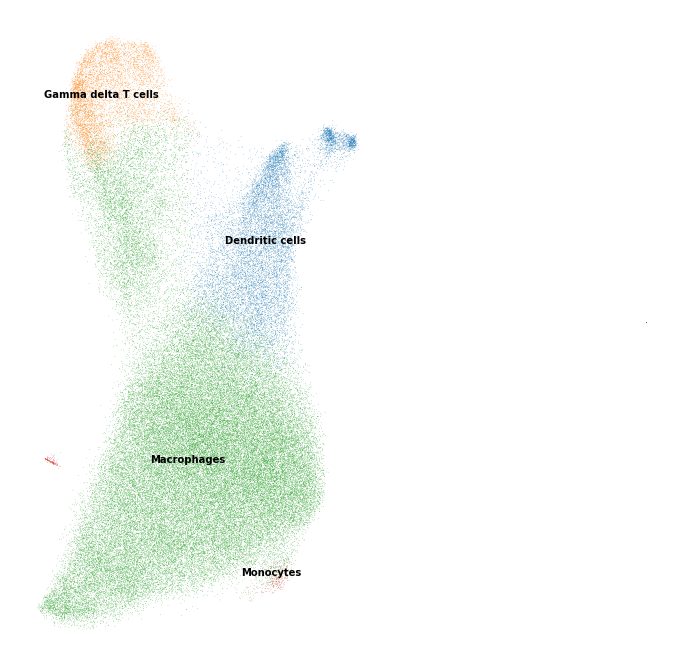

In [12]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(mdata, color='broadcelltype', legend_loc='on data', title='', frameon=False)

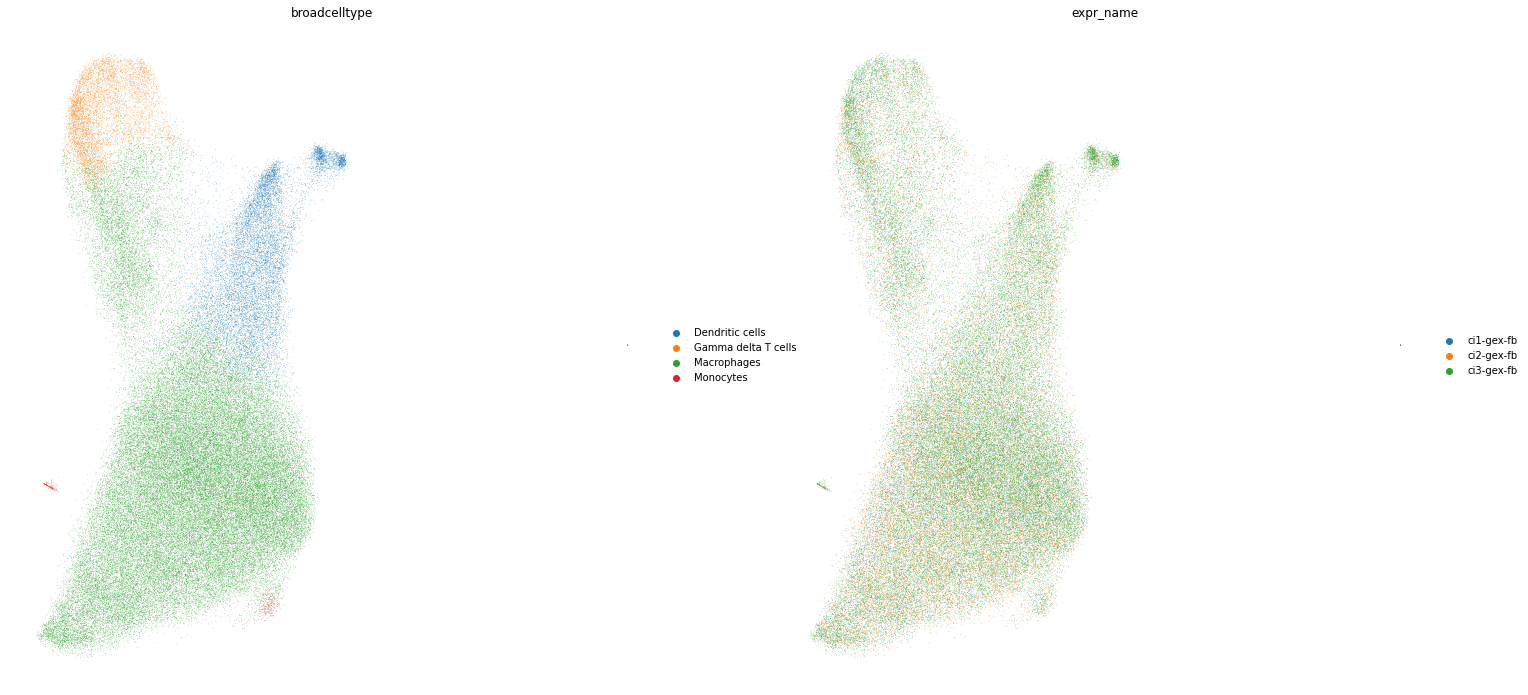

In [13]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(mdata, color=['broadcelltype', 'expr_name'], frameon=False)

In [14]:
mdata.obs['broadcelltype'].value_counts()

Macrophages            74026
Dendritic cells        13207
Gamma delta T cells     6503
Monocytes                373
Name: broadcelltype, dtype: int64

#### save the PanglaoDB based cell-types

In [15]:
mdata.obs.to_csv(pangloa_cell_types)

#### parse in MACA marker database, using Bakken

In [16]:
markers_df = pd.read_csv(bakken_db_url)
print(markers_df.shape)
display(markers_df.head())
#cell_marker is dictionary that contains names of cell types and their marker genes
cell_markers = {}
marker_list = []
for i in list(set(markers_df.columns.values.tolist())):
    genes = markers_df[i].values.tolist()
    cell_markers[i]=genes
    marker_list+= genes
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)

(20, 20)


,Pvalb,L5 IT,Sst,OPC,L6 IT Car3,VLMC,L5/6 NP,L6b,Vip,L6 CT,Endo,L6 IT,Astro,Sst Chodl,L2/3 IT,Oligo,Micro-PVM,L5 ET,Sncg,Lamp5
0,ADAMTS17,LOC105374971,SST,VCAN,LOC105378486,COLEC12,NPSR1-AS1,LOC401134,VIP,ADAMTSL1,ABCB1,LOC105371832,RNF219-AS1,NPY,CUX2,ST18,DOCK8,LOC105378657,CXCL14,FGF13
1,BTBD11,LOC105377703,GRIK1,LHFPL3,ZNF804B,LINC01088,HTR2C,MDFIC,GALNTL6,HS3ST4,FLT1,THEMIS,ADGRV1,NOS1,LINC00507,PLP1,ADAM28,COL5A2,CNR1,EYA4
2,ERBB4,LOC102546299,NXPH1,PDGFRA,TRPC5,LOC105377979,TSHZ2,HS3ST4,TAC3,SEMA3E,HERC2P3,LOC105373893,LOC101927437,CRHBP,LINC01378,MOBP,APBB1IP,LOC105369860,CHRNA7,KIT
3,CNTNAP3B,FSTL4,COL25A1,COL9A1,ATP10A,DCN,TLL1,MCTP2,ADARB2,LOC105373592,MECOM,ADAMTS3,AQP4,SST,CA10,ENPP2,P2RY12,VAT1L,ADARB2,PDGFD
4,LOC101929680,RORB,FLT3,PTPRZ1,NTNG2,LOC102467224,ITGA8,NPFFR2,SYNPR,EGFEM1P,ABCG2,LOC101928278,SLC1A2,STAC,HS6ST3,LOC101927967,ST6GAL1,LOC101927745,NR2F2-AS1,PRELID2


221

#### compute MACA cell assignments

In [17]:
%%time
mdata = adata.copy()
mdata = mdata[:,marker_list]

##run MACA
mdata, annotation = maca.singleMACA(ad=mdata, cell_markers=cell_markers,
                                 res=[0.5,0.75,1,1.25,1.5],n_neis=[3,5,10,30,50,100])
##we define louvain clustering resolution 1, 1.5 and 2; 
##number of neighbors to define the kNN is 3,5 and 10 separately.
##MACA will get 9 clustering results, using this set of parameteres.
##The final annotation is ensembled via voting.

Trying to set attribute `.obs` of view, copying.


(94109, 20)
(94109, 20)
CPU times: user 3h 1min 55s, sys: 2h 11min 26s, total: 5h 13min 21s
Wall time: 41min 45s


In [18]:
mdata.obs['celltype'] = np.array(annotation)

#### visualize the MACA cell assignments

... storing 'Mapped' as categorical
... storing 'celltype' as categorical


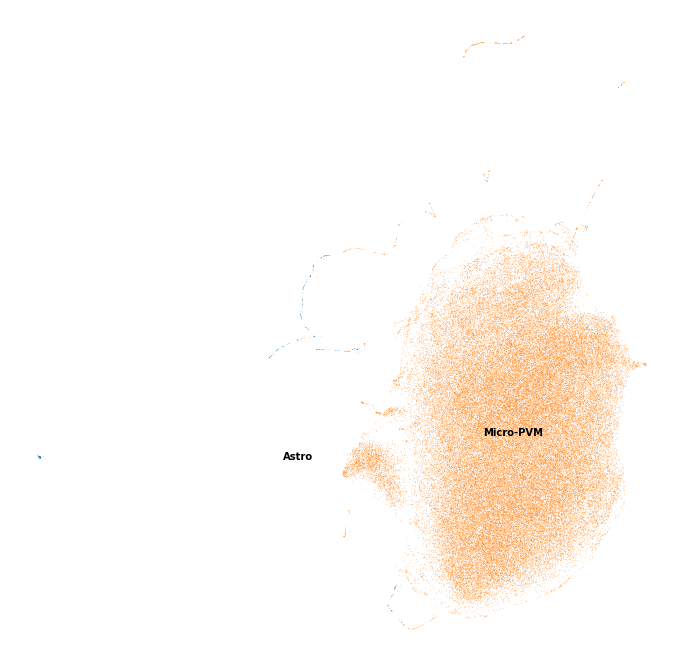

In [19]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(mdata, color='celltype', legend_loc='on data', title='', frameon=False)

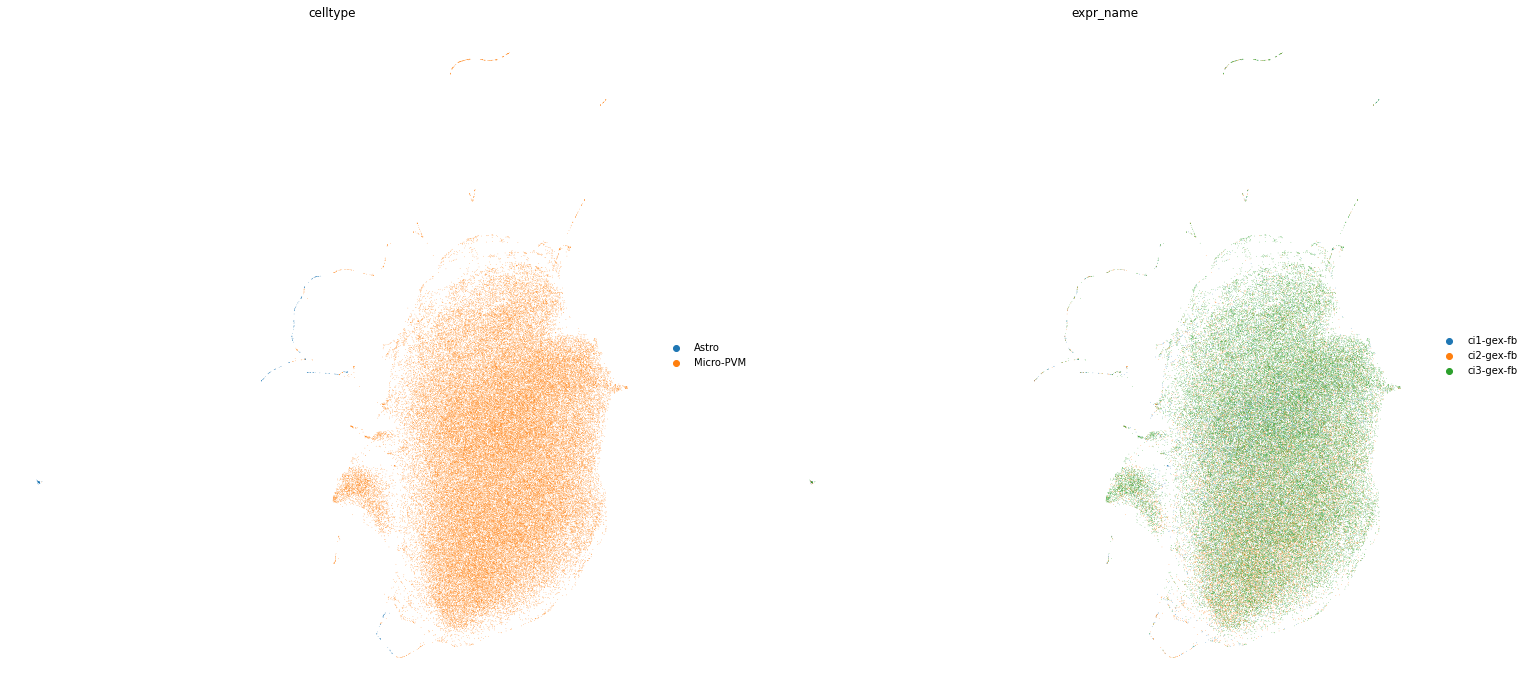

In [20]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(mdata, color=['celltype', 'expr_name'], frameon=False)

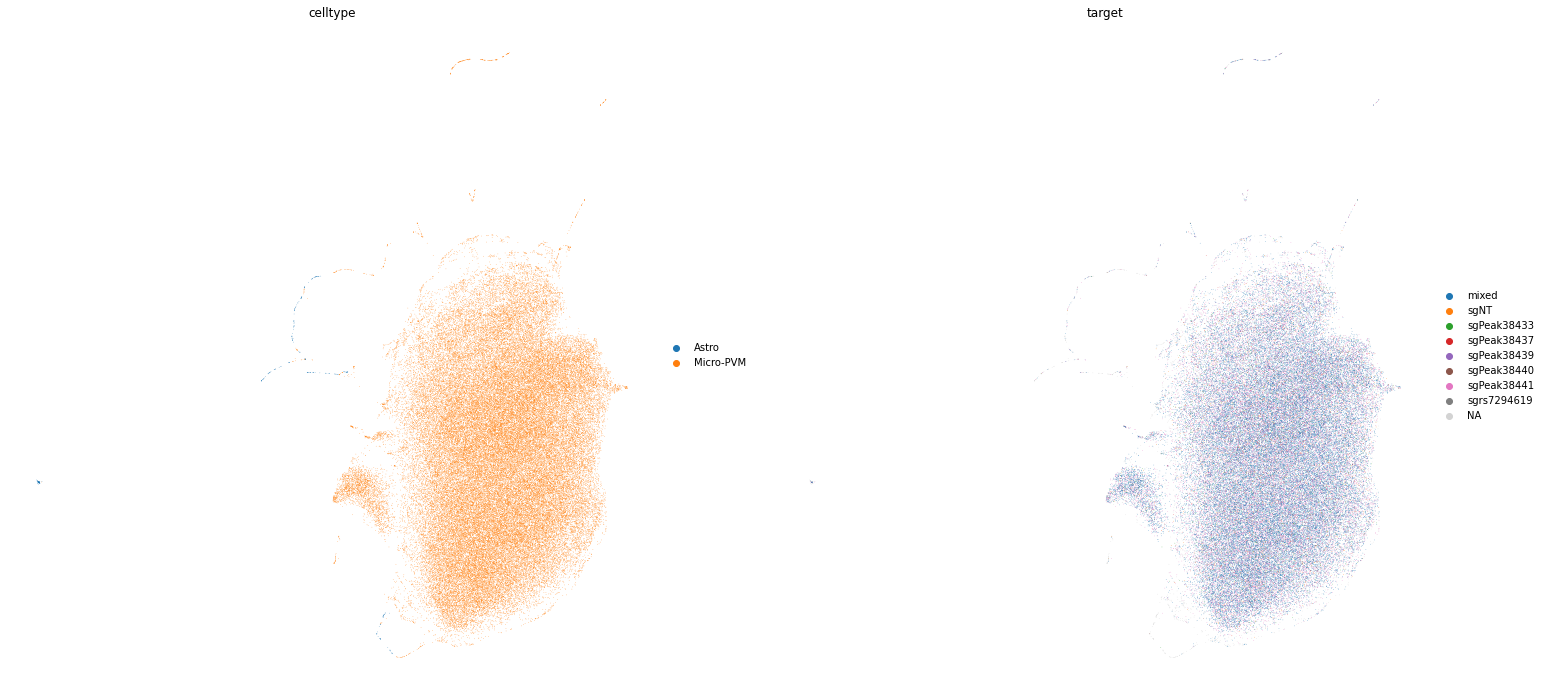

In [25]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(mdata, color=['celltype', 'target'], frameon=False)

In [21]:
mdata.obs['celltype'].value_counts()

Micro-PVM    93748
Astro          361
Name: celltype, dtype: int64

#### save the Bakken based cell-types

In [22]:
mdata.obs.to_csv(bakken_cell_types)

In [23]:
mdata.obs.head()

,expr_name,num_features,feature_call,num_umis,target,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,Label1,louvain,Mapped,celltype
AAACCCAAGACTACGG-1,ci1-gex-fb,NaN,NaN,NaN,NaN,2208,2208,7911.0,534.0,6.750095,6,17,0,Micro-PVM
AAACCCAAGCACTAAA-1,ci1-gex-fb,3.0,sgPeak38437_29|sgPeak38441_134|sgPeak38441_319,314|13|230,mixed,4996,4996,27407.0,1479.0,5.396432,6,0,0,Micro-PVM
AAACCCAAGCCGGAAT-1,ci1-gex-fb,4.0,sgPeak38441_211|sgPeak38441_310|sgPeak38441_33...,136|5|69|25,sgPeak38441,4591,4591,26085.0,1379.0,5.286563,6,0,0,Micro-PVM
AAACCCAAGGCTCAAG-1,ci1-gex-fb,2.0,sgPeak38441_04|sgPeak38441_266,13|31,sgPeak38441,5753,5753,34377.0,2620.0,7.621375,6,18,0,Micro-PVM
AAACCCAAGTTTGCTG-1,ci1-gex-fb,4.0,sgNT_24|sgNT_49|sgPeak38433_38|sgPeak38441_196,4|9|14|16,mixed,3745,3745,14111.0,939.0,6.654383,6,2,0,Micro-PVM


In [24]:
mdata.obs['celltype'].value_counts()

Micro-PVM    93748
Astro          361
Name: celltype, dtype: int64